In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import hybrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from dwave.cloud.api import Problems
import json
import time
from scipy.optimize import curve_fit
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors

from dwave.embedding.chain_breaks import majority_vote, broken_chains
import dimod

def unembed_sampleset_mine(sampleset, embedding, bqm, chain_break_fraction=False):
    variables = list(bqm.variables)  # need this ordered
    try:
        chains = [embedding[v] for v in variables]
    except KeyError:
        raise ValueError("given bqm does not match the embedding")

    record = sampleset.record

    unembedded, idxs = majority_vote(sampleset, chains)

    reserved = {'sample', 'energy'}
    vectors = {name: record[name][idxs]
            for name in record.dtype.names if name not in reserved}
    
    if chain_break_fraction:
        broken = broken_chains(sampleset, chains)
        if broken.size:
            vectors['chain_break_fraction'] = broken.mean(axis=1)[idxs]
        else:
            vectors['chain_break_fraction'] = 0

    info = sampleset.info.copy()

    return dimod.SampleSet.from_samples_bqm((unembedded, variables),
                                            bqm,
                                            info=info,
                                            **vectors)


In [2]:
with open("pickles/RQ1.2_extended.pkl" , "rb") as f:
    [acl, num_qubits, energies, unembedded_energies, reference_energies, relative_errors, unembedded_relative_errors, broken_chain_fractions] = pickle.load(f)
median_relative_errors = np.median(relative_errors, axis = -1)
median_unembedded_relative_errors = np.median(unembedded_relative_errors, axis = -1)
median_broken_chain_fractions = np.median(broken_chain_fractions, axis = -1)

min_relative_errors = np.min(relative_errors, axis = -1)
min_unembedded_relative_errors = np.min(unembedded_relative_errors, axis = -1)
min_broken_chain_fractions = np.min(broken_chain_fractions, axis = -1)

prefactors = [0.5, 0.75, 1, 1.414, 2]

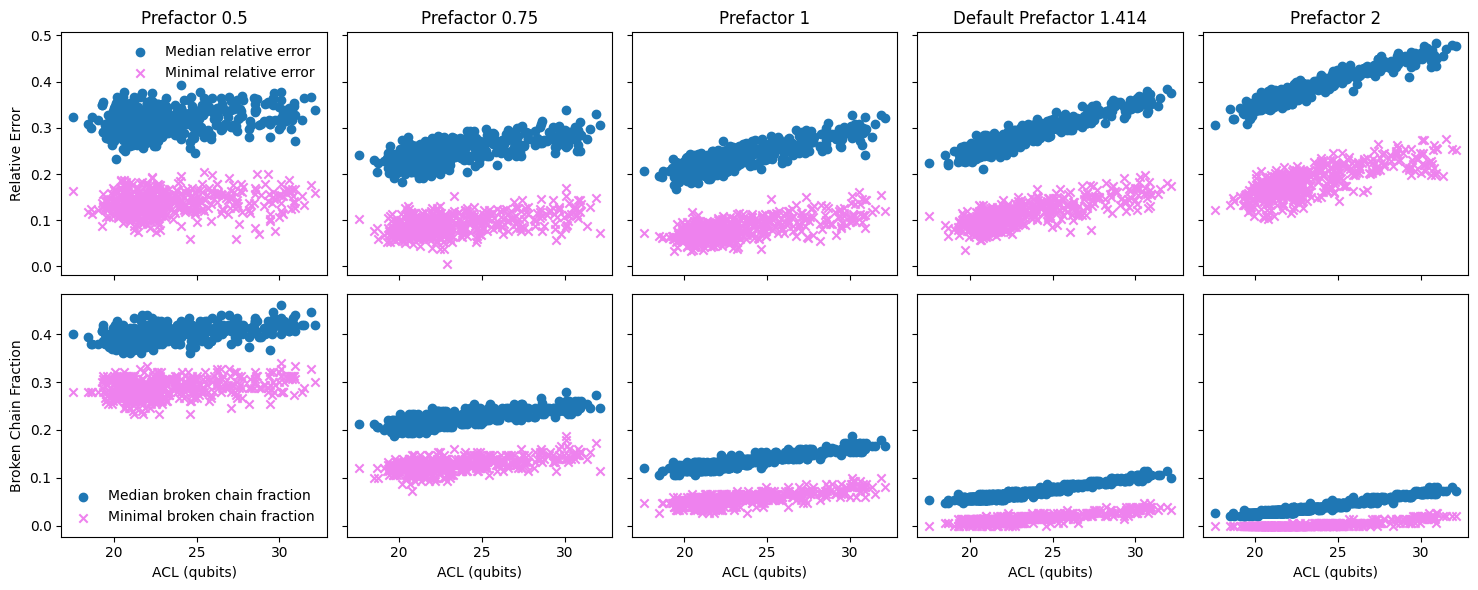

In [22]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row', figsize=(15, 6))

# left
axs[0, 0].scatter(acl, median_unembedded_relative_errors[:, :, 2], label='Median relative error')
axs[0, 0].scatter(acl, min_unembedded_relative_errors[:, :, 2], label='Minimal relative error', color='violet', marker='x')
axs[0, 0].set_ylabel('Relative Error')
# axs[0, 0].legend()
axs[1, 0].scatter(acl, median_broken_chain_fractions[:, :, 2], label='Median broken chain fraction')
axs[1, 0].scatter(acl, min_broken_chain_fractions[:, :, 2], label='Minimal broken chain fraction', color='violet', marker='x')
axs[1, 0].set_xlabel('ACL (qubits)')
axs[1, 0].set_ylabel('Broken Chain Fraction')
axs[0, 0].set_title(f'Prefactor {prefactors[0]}')


# center-left
axs[0, 1].scatter(acl, min_unembedded_relative_errors[:, :, 4], label='Minimal relative error', color='violet', marker='x')
axs[0, 1].scatter(acl, median_unembedded_relative_errors[:, :, 4], label='Postprocessed solutions')
# axs[0, 1].legend()
axs[1, 1].scatter(acl, median_broken_chain_fractions[:, :, 4], label='Median broken chain fraction')
axs[1, 1].scatter(acl, min_broken_chain_fractions[:, :, 4], label='Minimal broken chain fraction', color='violet', marker='x')
axs[1, 1].set_xlabel('ACL (qubits)')
axs[0, 1].set_title(f'Prefactor {prefactors[1]}')

# center
axs[0, 2].scatter(acl, min_unembedded_relative_errors[:, :, 3], label='Minimal relative error', color='violet', marker='x')
axs[0, 2].scatter(acl, median_unembedded_relative_errors[:, :, 3], label='Postprocessed solutions')
# axs[0, 2].legend()
axs[1, 2].scatter(acl, median_broken_chain_fractions[:, :, 3], label='Median broken chain fraction')
axs[1, 2].scatter(acl, min_broken_chain_fractions[:, :, 3], label='Minimal broken chain fraction', color='violet', marker='x')
axs[1, 2].set_xlabel('ACL (qubits)')
axs[0, 2].set_title(f'Prefactor {prefactors[2]}')


# center-right
axs[0, 3].scatter(acl, min_unembedded_relative_errors[:, :, 0], label='Minimal relative error', color='violet', marker='x')
axs[0, 3].scatter(acl, median_unembedded_relative_errors[:, :, 0], label='Postprocessed solutions')
# axs[0, 3].legend()
axs[1, 3].scatter(acl, median_broken_chain_fractions[:, :, 0], label='Median broken chain fraction')
axs[1, 3].scatter(acl, min_broken_chain_fractions[:, :, 0], label='Minimal broken chain fraction', color='violet', marker='x')
axs[1, 3].set_xlabel('ACL (qubits)')
axs[0, 3].set_title(f'Default Prefactor {prefactors[3]}')

# right
axs[0, 4].scatter(acl, min_unembedded_relative_errors[:, :, 1], label='Minimal relative error', color='violet', marker='x')
axs[0, 4].scatter(acl, median_unembedded_relative_errors[:, :, 1], label='Postprocessed solutions')
# axs[0, 4].legend()
axs[1, 4].scatter(acl, median_broken_chain_fractions[:, :, 1], label='Median broken chain fraction')
axs[1, 4].scatter(acl, min_broken_chain_fractions[:, :, 1], label='Minimal broken chain fraction', color='violet', marker='x')
axs[1, 4].set_xlabel('ACL (qubits)')
axs[0, 4].set_title(f'Prefactor {prefactors[4]}')


axs[0, 0].legend(loc='upper right', frameon=False, fontsize = 10)
axs[1, 0].legend(loc='lower right', frameon=False, fontsize = 10)
plt.tight_layout()
plt.show()

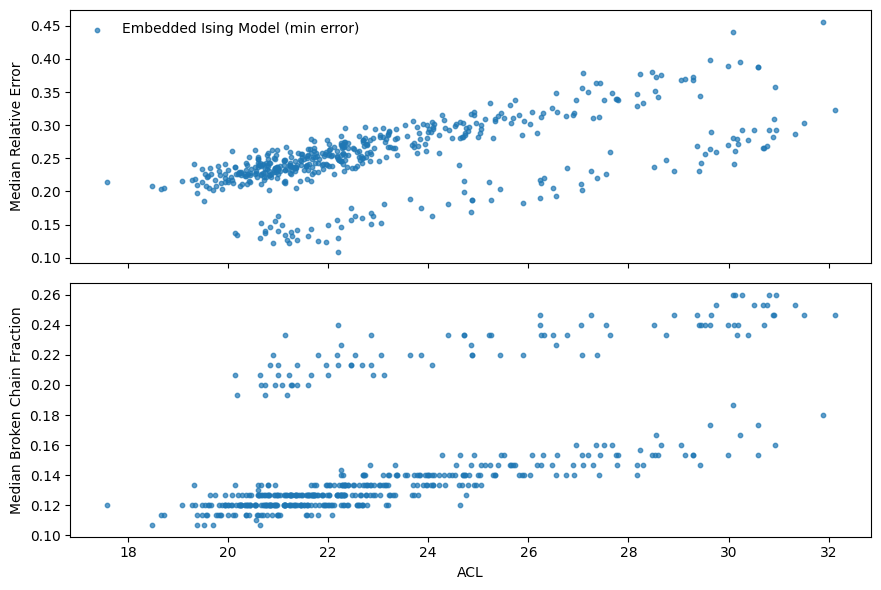

In [7]:
# Step 1: Find the index of the minimum error for each (i, j) over the last axis
best_prefactor_idx = np.argmin(median_unembedded_relative_errors, axis=2)  # shape (5, 100)

# Step 2: Create indices for fancy indexing
i_idx, j_idx = np.indices(best_prefactor_idx.shape)  # shapes (5, 100)

# Step 3: Extract the minimum error and corresponding values
min_relative_errors = median_relative_errors[i_idx, j_idx, best_prefactor_idx]  # shape (5, 100)
min_unembedded_errors = median_unembedded_relative_errors[i_idx, j_idx, best_prefactor_idx]
min_broken_chain_fractions = median_broken_chain_fractions[i_idx, j_idx, best_prefactor_idx]

# Step 4: Plot
fig, axs = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# Top subplot: Median Relative Errors
axs[0].scatter(acl, min_relative_errors, s=10, label='Embedded Ising Model (min error)', alpha=0.7)
# axs[0].scatter(acl, min_unembedded_errors, s=10, label='Postprocessed solutions', alpha=0.7)
axs[0].set_ylabel('Median Relative Error')
axs[0].legend(frameon=False)

# Bottom subplot: Broken Chain Fractions
axs[1].scatter(acl, min_broken_chain_fractions, s=10, alpha=0.7)
axs[1].set_xlabel('ACL')
axs[1].set_ylabel('Median Broken Chain Fraction')

plt.tight_layout()
plt.show()


In [6]:
np.nanargmin(median_unembedded_relative_errors, axis = -1)

array([[4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
        3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4],
       [4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
        3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3,
        3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3],
       [3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3,